In [42]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


+----------------------+
|Date                  |
+----------------------+
|08/25/2007 09:22:18 AM|
|05/24/2021 03:06:00 PM|
|06/26/2021 09:24:00 AM|
|11/09/2023 07:30:00 AM|
|11/12/2023 07:59:00 AM|
+----------------------+
only showing top 5 rows



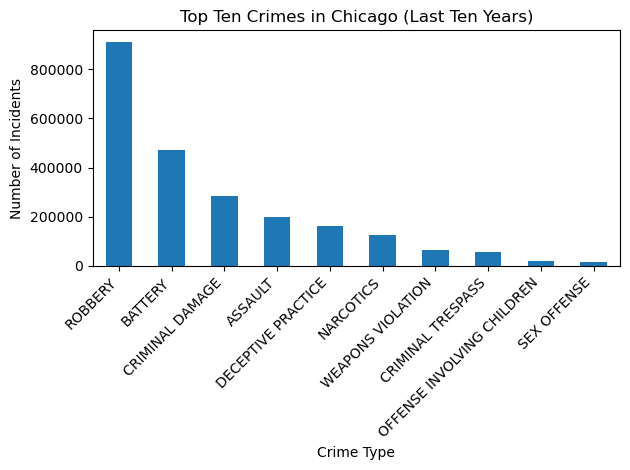

Year-wise trend of crime:


+----+------+
|Year| count|
+----+------+
|2014|256125|
|2015|239892|
|2016|248594|
|2017|246567|
|2018|245385|
|2019|240852|
|2020|193868|
|2021|187559|
|2022|219046|
|2023|243358|
|2024| 46158|
+----+------+

Hour of the day with the highest crime:


+----+------+
|Hour| count|
+----+------+
|  12|136753|
|  18|133135|
|   0|131554|
|  19|131485|
|  15|129194|
|  17|128321|
|  16|125894|
|  20|125848|
|  14|117629|
|  21|117340|
|  22|115497|
|  13|111761|
|  11|105644|
|   9|102022|
|  10|101928|
|  23| 98472|
|   8| 79383|
|   1| 75059|
|   2| 65372|
|   7| 56760|
+----+------+
only showing top 20 rows



In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, col, year, hour

# Create Spark session
spark = SparkSession.builder.appName("Chicago Crime Analysis").getOrCreate()

# Load Chicago crime data from CSV file
# Ensure the path to the CSV file is correct
crime_data = spark.read.csv("Crimes_-_2001_to_Present.csv", header=True, inferSchema=True)

# Show the first few rows to understand the Date format properly
crime_data.select("Date").show(5, truncate=False)

# From the output of the above command, adjust the format below to match your date strings
date_format = "MM/dd/yyyy hh:mm:ss a"  

# Cast Date column to timestamp
crime_data = crime_data.withColumn("Date", to_timestamp("Date", date_format))

# Remove all null values
crime_data = crime_data.dropna()

# Filter data for the last ten years
# As the current year is 2024, we filter from 2014 onwards
crime_data = crime_data.filter(year(col("Date")) >= 2014)

# Remove the records with the specified crime types
crime_types_to_exclude = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']
crime_data = crime_data.filter(~col("Primary Type").isin(crime_types_to_exclude))

# Merge similar crime types
crime_data = crime_data.withColumn(
    "Primary Type",
    when(col("Primary Type") == "PROSTITUTION", "SEX OFFENSE")
    .when(col("Primary Type") == "SEX OFFENSE", "SEX OFFENSE")
    .otherwise(col("Primary Type"))
)
crime_data = crime_data.withColumn(
    "Primary Type",
    when(col("Primary Type") == "BURGLARY", "ROBBERY")
    .when(col("Primary Type")=="THEFT", "ROBBERY")
    .when(col("Primary Type")=="MOTOR VEHICLE THEFT", "ROBBERY")
    .when(col("Primary Type") == "ROBBERY", "ROBBERY")
    .otherwise(col("Primary Type"))
)
# Analysis

# Show year-wise trend of crime for the last ten years
crime_trend = crime_data.groupBy(year(col("Date")).alias("Year")).count().orderBy("Year")

# Find out at which hour of the day crime is highest
crime_by_hour = crime_data.withColumn("Hour", hour("Date"))
hourly_crime = crime_by_hour.groupBy("Hour").count().orderBy(col("count").desc())

# Find top ten crimes and present them as a bar chart
top_ten_crimes = crime_data.groupBy("Primary Type").count().orderBy(col("count").desc()).limit(10)

# Collect the data for visualization
top_ten_crimes_df = top_ten_crimes.toPandas()

# Plotting the top ten crimes
top_ten_crimes_df.plot(kind='bar', x='Primary Type', y='count', legend=None)
plt.title('Top Ten Crimes in Chicago (Last Ten Years)')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show year-wise trend of crime for the last ten years
print("Year-wise trend of crime:")
crime_trend.show()

# Show at which hour of the day crime is highest
print("Hour of the day with the highest crime:")
hourly_crime.show()

# Remember to stop the Spark session when done
spark.stop()
